# Title: Marking lane lines

Table of contents:
1. Description of libraries used.
2. Read a sample image of road and convert it to grayscale.
3. Apply Gaussian smoothing.
4. Apply Canny Edge algorithm to detect the edges.
5. Mask unwanted part of image (ignore everything outside road)
6. Drawing lines.
7. Applying Hough transform.
8. Blending Images.
9. Marking lane lines in an image.
10. Slope filter for noise reduction.
11. Linear regression on a set of lines
12. Converting a video into frames.
13. Marking lane lines in a video.
14. Plotting embedded HTML for video.

### 1. Libraries used:
    1.1 matplotlib
    1.2 numpy
    1.3 cv2
    1.4 moviepy
    1.5 imageio
    1.6 math
 


In [1]:
import matplotlib.pyplot as plt


Provides a MATLAB-like plotting framework. This is very convenient for interactive work as mathematical plots can 
be easily done.
This imports the module "matplotlib.pyplot" and binds that to the name "plt".

In [2]:
import matplotlib.image as mpimg

This image module supports basic image loading, rescaling and display operations. This imports the module "matplotlib.image" and binds that to the name "mpimg"

In [3]:
import cv2

OpenCV (Open Source Computer Vision) is a library of programming functions mainly aimed at real-time computer vision.
OpenCV has a modular structure, which means that the package includes several shared or static libraries.

In [4]:
import numpy as np

NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays. It is the short form for numerical python package. 

In [5]:
import math

It provides access to the mathematical functions defined by the C standard

### 2. Read image and apply grayscale.

In [6]:
original_image = mpimg.imread('test_images/expressway4.jpg')

Reading the image using the function mpimg.imread() while accessing the library matplot.image. 

In [7]:
print('Image Dimensions: ', original_image.shape)

Image Dimensions:  (681, 1024, 3)


The image dimensions are displayed.

In [8]:
plt.figure() 

Creating the figure. 

In [9]:
plt.imshow(original_image) 

This function draws image onto the frame.

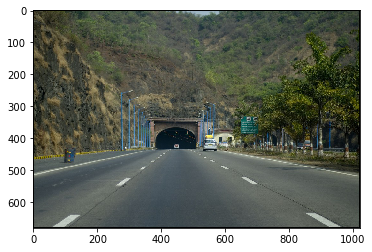

In [10]:
plt.show() 

In [11]:
def convert_to_gray(img):
   return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cvtColor() converts image from one color space to another. Here, the image is converted to grayscale. The converted image is assigned to a variable 'gray_image'. 

### 3. Applying Gaussian blur to an image

In [12]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

Image blurring is achieved by convolving the image with a low-pass filter kernel. It is useful for removing noises. It actually removes high frequency content (eg: noise, edges) from the image. We should specify the width and height of kernel which should be positive and odd. This makes only truly contrasting parts of the picture stand out for next steps. This helps smooth out the overall numbers in the image matrix that defines this picture. The
kernel_size is the amount of blur to be applied. The bigger the kernel size blurry the output.

### 4. Applying Canny edge detection algorithm on processed image



In [13]:

def canny_transform(img, low_threshold, high_threshold): 
    return cv2.Canny(img, low_threshold, high_threshold)

Canny() parses the pixel values according to their directional derivative (i.e. gradient). Leaving behind the edges or where there is a steep derivative in at least one direction. High and low threshold determine a minimum difference in intensity to establish an edge and to form a contiguous extension of an established  edge, respectively.

### Comparison of edge detection techniques:


1.Sobel Operator
    The operator consists of a pair of 3X3 convolution kernels.One kernel is simply the other rotated by 90'.
    These kernels are designed to respond maximally to edges running vertically and horizontaly relative to 
    pixel grid.The kernels can be applied separately to the input image,to produce separate measurements of 
    the gradient component in each orientation.
    
2.Robert's cross operator
    This operator performs a simple,quick to compute,2-D spatial gradient measurement on an image.This operator 
    consists of 2X2 concolution kernels.This is very similar to Sobel operator.
    
    
3.Canny Edge Detection Algorithm
    First step is to filter noise in the original image before trying to detect any edges.After filtering noise,
    Gaussian smoothening can be performed using standard convolution method.
    
    Second step is to find the edge strength by taking gradient of the image.
        
    Third step computes the direction of edge using the gradient in x and y direction.When the gradient in x 
    direction is equal to zero,the edge direction has to be equal to 90' or 0'.
    
    Fourth step relates the edge direction to a direction that can be traced in an image.
    
    In the Fifth step,non-maximum suppression has to be applied which is used to trace along the edge in the edge 
    direction .This will give a thin line in the output image.
    
    In the Sixth step,hysteresis is used to eliminate streaking.Streaking is the breaking up of an edge contour
    caused by the operator output fluctuating above and below the threshold.Hysteresis uses 2 thresholds a high
    and low.
    

Canny edge algorithm yielded the best results as compared  with the above 2.This was expected as this algorithm 
accounts for regions in an image.Algorithm yields thin lines for its edges by using non-maximal suppression.
Sobel and Robert's operator produced inaccurate ouputs and they are sensitive to noise.

Hence we are using Canny edge algorithm for lane detection.

### 5. Mask edges of an image. 
Given the position and orientation of the camera, we can assume that lanes will be located in the lower half of the image. We can just isolate that area using a trapezoid shape. While it may be tempting to hardcode the best possible place to look for lines, lines can move around as you drive. For this reason, a simple ratio to setup a polygonial shape is used. We apply a generous ratio as we don’t want our region to be too narrow resulting in missing lanes out of the region of interest.

In [14]:
def mask_image(img, vertices):
    mask = np.zeros_like(img)   #defining a blank mask 
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image 
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
   
    cv2.fillPoly(mask, vertices, ignore_mask_color) #filling pixels inside the polygon defined by vertices with the fill color 
    masked_image = cv2.bitwise_and(img, mask) #returning the image only where mask pixels are nonzero
    return masked_image

Filling pixels inside the polygon defined by "vertices" with the fill color.

### 6. Draw Lines
This function draws lines with color and thickness.Lines are drawn on the image inplace (mutates the image).
In previous module road region was hardcoded. As, lines can move around as user drives (as user moves relative to the lines) and it reduced accuracy if they moved out of the ROI frame. For this reason, a simple ratio to setup polygons for left and right ROI is used.

In [15]:
def draw_lines(img, left, right, color=[255, 0, 0], thickness=2):
    global prev
    # If we have no lines at all
    if len(left) == 0 or len(right) == 0:
        return img
    
    # Run linear regression and get slopes and intercepts
    left_x, left_y, left_m, left_c = lines_linear_regression(left)
    right_x, right_y, right_m, right_c = lines_linear_regression(right)

    # This variable represents the top-most point in the image where we can reasonable draw a line to.
    min_y = np.min([np.min(left_y), np.min(right_y)])

    # Calculate the top left and top right points using the slopes and intercepts we got from linear regression.
    top_right_point = np.array([(min_y - right_c) / right_m, min_y], dtype=int)
    top_left_point = np.array([(min_y - left_c) / left_m, min_y], dtype=int)

    # Repeat this process to find the bottom left and bottom right points.
    max_y = np.max([np.max(right_y), np.max(left_y)])
    bottom_left_point = np.array([(max_y - left_c) / left_m, max_y], dtype=int)
    bottom_right_point = np.array([(max_y - right_c) / right_m, max_y], dtype=int)

    # Draw the lines.
    cv2.line(img, (bottom_left_point[0], bottom_left_point[1]), (top_left_point[0], top_left_point[1]), [255, 0, 0], thickness)
    cv2.line(img, (bottom_right_point[0], bottom_right_point[1]), (top_right_point[0], top_right_point[1]), [255, 0, 0], thickness)
    return img

### 7. Hough transform: 
Using probabilistic Hough lines, we identify the location of lane lines on the road. 
The Hough transform algorithm extracts all the lines passing through each of our edge points and group them by similarity. The HoughLinesP function in OpenCV returns an array of lines organized by endpoints (x1, x1, x2, x2). It’s important to understand that we are no longer viewing point in the (x, y) cartesian coordinate system but are now viewing points in the (ρ, θ) polar coordinate system that the Hough transform operates in. 


In [16]:
def draw_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    return lines



The Hough transform takes a resolution for line position and orientation, a minimum number of points to establish a line, the minimum length of a line, and the maximum gap between points allowed for a line.

rho - distance resolution in pixels of the Hough grid

theta - angular resolution in radians of the Hough grid

threshold - minimum number of votes (intersections in Hough grid cell)

min_line_len - minimum number of pixels making up a line

max_line_gap - maximum gap in pixels between connectable line segments
    

### 8.Blend images

The result image is computed as : initial_img\*alpha + img\*beta + gamma
By varying alpha from 0 to 1 this operator can be used to perform a temporal cross-dissolve between two images or videos

In [17]:
def blend_images(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)

initial_img \* alpha + img \* beta + gamma


alpha – weight of the first array elements.

beta – weight of the second array elements.

gamma – scalar added to each sum.

### 9. Slope Filter
For processing and making an educated guess as there where the lanes are, then using that same logic to draw lines spanning the lane edges, not
just where the lane markings appear.

Slope filter takes an array of lines and gives back lines which have a valid slope, given a range

In [18]:
def check_slope_range(lines_array, positive, min_slope, max_slope):
    slopes = np.apply_along_axis(lambda row: (row[3] - row[1]) / (row[2] - row[0]), 2, lines_array)

    if positive:
        slopes[slopes > max_slope] = 0
        slopes[slopes < min_slope] = 0
        lines_array = np.array(lines_array[np.where(slopes > 0)])
    else:
        slopes[slopes < -max_slope] = 0
        slopes[slopes > -min_slope] = 0
        lines_array = np.array(lines_array[np.where(slopes < 0)])

    return lines_array

### 11. Regression 
Performs simple linear regression Linear Programming on a set of lines. Fits a line, y = mx + c, through some noisy data-points.

In [19]:
def lines_linear_regression(lines_array):
    # Select the 0th and 2nd index which will provide the xval and reshape to extract x values
    x = np.reshape(lines_array[:, [0, 2]], (1, len(lines_array) * 2))[0]
    # Select the 1st and 3rd index which will provide the yval and reshape to extract y values
    y = np.reshape(lines_array[:, [1, 3]], (1, len(lines_array) * 2))[0]
    #Stack arrays in sequence vertically (row wise).Take a sequence of arrays and stack them vertically to make a single array.
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    x = np.array(x)
    y = np.array(x * m + c)
    return x, y, m, c


If we have a line, y = mx + c, through some noisy data-points, By examining the coefficients, we see that the line should have a gradient of roughly g1 and cut the y-axis at, more or less, y0. We can rewrite the line equation as y = Ap, where A = [[x 1]] and p = [[m], [c]].

numpy.linalg.lstsq(a, b, rcond=-1)
Return the least-squares solution to a linear matrix equation.

Solves the equation a x = b by computing a vector x that minimizes the Euclidean 2-norm || b - a x ||^2. The equation may be under-, well-, or over- determined (i.e., the number of linearly independent rows of a can be less than, equal to, or greater than its number of linearly independent columns). If a is square and of full rank, then x (but for round-off error) is the “exact” solution of the equation.

### 9. Main Function 
Sequence of function calls to detect lanes

In [20]:
def process_image(image, verbose=False):
    img_shape = image.shape

    if verbose:
        print('Processing image.')

    width = img_shape[1]
    height = img_shape[0]
    #setup polygons for left and right
    ratio = 5/8

    mask_left = np.array([[
        (100, height),
        ((1 - ratio) * width, ratio * height),
        (.5 * width, ratio * height),
        (.5 * width, height)
    ]], dtype=np.int32)

    mask_right = np.array([[
        (.5 * width, height),
        (.5 * width, ratio * height),
        (ratio * width, ratio * height),
        (width, height)
    ]], dtype=np.int32)

    canny_low_threshold = 80
    canny_high_threshold = 200
    
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 20  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20  # minimum number of pixels making up a line
    max_line_gap = 10  # maximum gap in pixels between connectable line segments
    
    gaussian_kernel = 5

    
    grey_image = convert_to_gray(image)
    plt.subplot(231)
    plt.imshow(grey_image, cmap='gray')

    blur_grey_image = gaussian_blur(grey_image, gaussian_kernel)
    plt.subplot(232)
    plt.imshow(blur_grey_image, cmap='gray')

    canny_edge_image = canny_transform(blur_grey_image, canny_low_threshold, canny_high_threshold)
    plt.subplot(233)
    plt.imshow(canny_edge_image, cmap='gray')

    img = cv2.dilate(canny_edge_image, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)))

    edges_left = mask_image(img, [mask_left])
    edges_right = mask_image(img, [mask_right])
    plt.subplot(234)
    plt.imshow(edges_left, cmap='gray')
    plt.subplot(235)
    plt.imshow(edges_right, cmap='gray')

    hough_left = draw_hough_lines(edges_left, rho, theta, threshold, min_line_length, max_line_gap)
    hough_right = draw_hough_lines(edges_right, rho, theta, threshold, min_line_length, max_line_gap)

    if hough_left is None or hough_right is None:
        return image

    lines_left = check_slope_range(hough_left, False, .5, .9)
    lines_right = check_slope_range(hough_right, True, .5, .9)

    color_with_lines = np.zeros(image.shape, dtype=np.uint8)
    color_with_lines = draw_lines(color_with_lines, lines_left, lines_right, [255, 0, 0], 10)
    final_image = blend_images(color_with_lines, image)
    plt.subplot(236)
    plt.imshow(final_image)

    if verbose:
        plt.show()
    return final_image
    

    
    

Processing image.


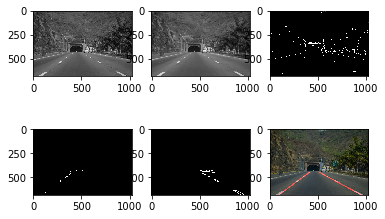

array([[[ 0,  0,  4],
        [ 0,  1,  3],
        [ 2,  2,  4],
        ..., 
        [ 5,  6,  7],
        [ 0,  0,  3],
        [ 9, 10, 13]],

       [[ 2,  6,  8],
        [ 0,  1,  2],
        [ 4,  4,  4],
        ..., 
        [10, 10, 12],
        [ 0,  0,  2],
        [ 0,  0,  2]],

       [[ 0,  1,  0],
        [ 4,  6,  3],
        [26, 27, 23],
        ..., 
        [42, 43, 42],
        [ 6,  8,  7],
        [ 2,  4,  3]],

       ..., 
       [[ 0,  1,  0],
        [ 9, 10,  8],
        [51, 53, 50],
        ..., 
        [48, 50, 47],
        [ 7,  9,  6],
        [ 0,  1,  0]],

       [[ 6,  7,  5],
        [ 0,  1,  0],
        [ 3,  5,  2],
        ..., 
        [ 6,  7,  6],
        [ 0,  1,  0],
        [ 0,  1,  0]],

       [[ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0],
        ..., 
        [ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0]]], dtype=uint8)

In [21]:
process_image(original_image,verbose=True)

Above image was captured on Pune-Mumbai Expressway near Katraj. It is not captured with the calibrated dash camera / action camera. It contains noise. Slope filter and regression helped in noise reduction. A better output can be seen on image from a calibrated camera. 

Processing image.


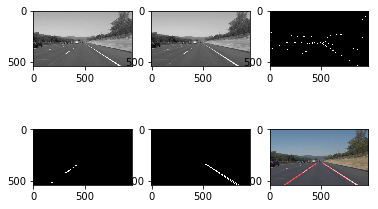

array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ..., 
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ..., 
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ..., 
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ..., 
       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ..., 
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ..., 
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ..., 
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144,

In [22]:
original_image = mpimg.imread('test_images/expressway3.jpg')
process_image(original_image,verbose=True)

### 10. Converting a video into frames

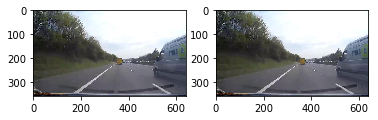

In [23]:
from moviepy.editor import VideoFileClip

clip1 = VideoFileClip("test.mp4").subclip(0,5)  #read video
clip2 = VideoFileClip("test.mp4").subclip(5,6) #select the subclip between t=5s and t=6s
clip2.save_frame("genrated_frame.jpeg") #save frame at 0s
image1 = mpimg.imread("genrated_frame.jpeg")

clip1.save_frame("genrated_frame.jpeg", t=5) #save frame at 5s
image2 = mpimg.imread("genrated_frame.jpeg")

plt.subplot(2,2,1)
plt.imshow(image1)
plt.subplot(2,2,2)
plt.imshow(image2)
plt.show()


Moviepy is a python library for video editing. The functions used are VideoFileClip() meaning the clip is read and a subclip is selected.
Then using function name.save-frame(), the frame is saved and we get the frame. 

### 11. Detecting Lanes in video

Following function calls above steps for each video frame

In [24]:
def process_video(image):
    result = process_image(image)
    print(result.shape)
    return result

### 12. Splitting into frames and plotting

In [25]:
from IPython.display import HTML

Embeds rendered HTML output into iPython output

In [26]:
get_ipython().magic('matplotlib inline')

get_ipython() returns the current ipython shell object.The iPython magic command %matplotlib inline makes plots appear within the Jupyter notebook instead of in a separate window, but the regular Python interpreter doesn’t understand iPython magic commands.

(360, 640, 3)
[MoviePy] >>>> Building video test_op.mp4
[MoviePy] Writing video test_op.mp4


  0%|          | 0/151 [00:00<?, ?it/s]

(360, 640, 3)
(360, 640, 3)

  1%|▏         | 2/151 [00:00<00:17,  8.74it/s]

  2%|▏         | 3/151 [00:00<00:17,  8.58it/s]

(360, 640, 3)


  3%|▎         | 4/151 [00:00<00:17,  8.36it/s]

(360, 640, 3)


  3%|▎         | 5/151 [00:00<00:17,  8.28it/s]

(360, 640, 3)


  4%|▍         | 6/151 [00:00<00:17,  8.44it/s]

(360, 640, 3)


  5%|▍         | 7/151 [00:00<00:16,  8.74it/s]

(360, 640, 3)


  5%|▌         | 8/151 [00:00<00:16,  8.85it/s]

(360, 640, 3)


  6%|▌         | 9/151 [00:01<00:15,  8.98it/s]

(360, 640, 3)


  7%|▋         | 10/151 [00:01<00:15,  8.94it/s]

(360, 640, 3)


  7%|▋         | 11/151 [00:01<00:15,  9.06it/s]

(360, 640, 3)


  8%|▊         | 12/151 [00:01<00:15,  9.15it/s]

(360, 640, 3)


  9%|▊         | 13/151 [00:01<00:14,  9.32it/s]

(360, 640, 3)
(360, 640, 3)


 10%|▉         | 15/151 [00:01<00:14,  9.64it/s]

(360, 640, 3)


 11%|█         | 16/151 [00:01<00:14,  9.52it/s]

(360, 640, 3)


 11%|█▏        | 17/151 [00:01<00:13,  9.60it/s]

(360, 640, 3)
(360, 640, 3)


 12%|█▏        | 18/151 [00:01<00:13,  9.64it/s]

(360, 640, 3)


 13%|█▎        | 20/151 [00:02<00:13,  9.90it/s]

(360, 640, 3)
(360, 640, 3)


 16%|█▌        | 24/151 [00:02<00:12, 10.24it/s]

(360, 640, 3)
(360, 640, 3)
(360, 640, 3)


 17%|█▋        | 26/151 [00:02<00:12, 10.32it/s]

(360, 640, 3)
(360, 640, 3)
(360, 640, 3)


 19%|█▊        | 28/151 [00:02<00:11, 10.31it/s]

(360, 640, 3)
(360, 640, 3)


 21%|██        | 31/151 [00:03<00:12,  9.73it/s]

(360, 640, 3)
(360, 640, 3)


 22%|██▏       | 33/151 [00:03<00:12,  9.21it/s]

(360, 640, 3)
(360, 640, 3)


 23%|██▎       | 35/151 [00:03<00:13,  8.56it/s]

(360, 640, 3)
(360, 640, 3)


 25%|██▍       | 37/151 [00:03<00:12,  8.98it/s]

(360, 640, 3)
(360, 640, 3)


 26%|██▌       | 39/151 [00:04<00:13,  8.60it/s]

(360, 640, 3)
(360, 640, 3)


 27%|██▋       | 41/151 [00:04<00:13,  8.34it/s]

(360, 640, 3)
(360, 640, 3)


 28%|██▊       | 43/151 [00:04<00:13,  7.87it/s]

(360, 640, 3)
(360, 640, 3)


 30%|██▉       | 45/151 [00:04<00:13,  7.75it/s]

(360, 640, 3)
(360, 640, 3)


 31%|███       | 47/151 [00:05<00:12,  8.22it/s]

(360, 640, 3)
(360, 640, 3)


 32%|███▏      | 49/151 [00:05<00:12,  8.28it/s]

(360, 640, 3)
(360, 640, 3)


 34%|███▍      | 51/151 [00:05<00:12,  7.74it/s]

(360, 640, 3)
(360, 640, 3)


 35%|███▌      | 53/151 [00:05<00:12,  7.81it/s]

(360, 640, 3)
(360, 640, 3)


 36%|███▋      | 55/151 [00:06<00:11,  8.00it/s]

(360, 640, 3)
(360, 640, 3)


 38%|███▊      | 57/151 [00:06<00:12,  7.57it/s]

(360, 640, 3)
(360, 640, 3)


 39%|███▉      | 59/151 [00:06<00:12,  7.48it/s]

(360, 640, 3)
(360, 640, 3)


 40%|████      | 61/151 [00:07<00:12,  7.43it/s]

(360, 640, 3)
(360, 640, 3)


 42%|████▏     | 63/151 [00:07<00:12,  6.92it/s]

(360, 640, 3)
(360, 640, 3)


 43%|████▎     | 65/151 [00:07<00:12,  6.79it/s]

(360, 640, 3)
(360, 640, 3)


 44%|████▍     | 67/151 [00:07<00:13,  6.40it/s]

(360, 640, 3)
(360, 640, 3)


 45%|████▌     | 68/151 [00:08<00:13,  6.35it/s]

(360, 640, 3)
(360, 640, 3)


 47%|████▋     | 71/151 [00:08<00:13,  5.79it/s]

(360, 640, 3)
(360, 640, 3)


 48%|████▊     | 73/151 [00:09<00:13,  5.91it/s]

(360, 640, 3)
(360, 640, 3)


 50%|████▉     | 75/151 [00:09<00:12,  5.88it/s]

(360, 640, 3)
(360, 640, 3)


 51%|█████     | 77/151 [00:09<00:11,  6.65it/s]

(360, 640, 3)
(360, 640, 3)


 52%|█████▏    | 79/151 [00:09<00:10,  6.77it/s]

(360, 640, 3)
(360, 640, 3)


 54%|█████▎    | 81/151 [00:10<00:11,  6.34it/s]

(360, 640, 3)
(360, 640, 3)


 55%|█████▍    | 83/151 [00:10<00:10,  6.51it/s]

(360, 640, 3)
(360, 640, 3)


 56%|█████▋    | 85/151 [00:10<00:09,  6.61it/s]

(360, 640, 3)
(360, 640, 3)


 58%|█████▊    | 87/151 [00:11<00:10,  6.32it/s]

(360, 640, 3)
(360, 640, 3)


 58%|█████▊    | 88/151 [00:11<00:09,  6.32it/s]

(360, 640, 3)


 60%|█████▉    | 90/151 [00:11<00:09,  6.35it/s]

(360, 640, 3)
(360, 640, 3)


 61%|██████    | 92/151 [00:11<00:08,  6.64it/s]

(360, 640, 3)
(360, 640, 3)


 62%|██████▏   | 94/151 [00:12<00:08,  6.87it/s]

(360, 640, 3)
(360, 640, 3)


 64%|██████▎   | 96/151 [00:12<00:08,  6.40it/s]

(360, 640, 3)
(360, 640, 3)


 65%|██████▍   | 98/151 [00:12<00:08,  6.11it/s]

(360, 640, 3)
(360, 640, 3)


 66%|██████▌   | 100/151 [00:13<00:07,  6.89it/s]

(360, 640, 3)
(360, 640, 3)


 68%|██████▊   | 102/151 [00:13<00:06,  7.02it/s]

(360, 640, 3)
(360, 640, 3)


 69%|██████▉   | 104/151 [00:13<00:06,  6.90it/s]

(360, 640, 3)
(360, 640, 3)


 70%|███████   | 106/151 [00:14<00:06,  7.17it/s]

(360, 640, 3)
(360, 640, 3)


 72%|███████▏  | 108/151 [00:14<00:05,  7.52it/s]

(360, 640, 3)
(360, 640, 3)


 73%|███████▎  | 110/151 [00:14<00:05,  7.09it/s]

(360, 640, 3)
(360, 640, 3)


 74%|███████▎  | 111/151 [00:14<00:05,  6.77it/s]

(360, 640, 3)
(360, 640, 3)


 75%|███████▌  | 114/151 [00:15<00:05,  6.29it/s]

(360, 640, 3)
(360, 640, 3)


 77%|███████▋  | 116/151 [00:15<00:05,  6.47it/s]

(360, 640, 3)
(360, 640, 3)


 78%|███████▊  | 118/151 [00:15<00:05,  6.30it/s]

(360, 640, 3)
(360, 640, 3)


 79%|███████▉  | 120/151 [00:16<00:04,  6.41it/s]

(360, 640, 3)
(360, 640, 3)


 81%|████████  | 122/151 [00:16<00:04,  6.17it/s]

(360, 640, 3)
(360, 640, 3)


 82%|████████▏ | 124/151 [00:16<00:04,  5.55it/s]

(360, 640, 3)
(360, 640, 3)


 83%|████████▎ | 126/151 [00:17<00:04,  5.72it/s]

(360, 640, 3)
(360, 640, 3)


 85%|████████▍ | 128/151 [00:17<00:03,  5.85it/s]

(360, 640, 3)
(360, 640, 3)


 86%|████████▌ | 130/151 [00:17<00:03,  5.86it/s]

(360, 640, 3)
(360, 640, 3)


 87%|████████▋ | 132/151 [00:18<00:03,  5.89it/s]

(360, 640, 3)
(360, 640, 3)


 89%|████████▊ | 134/151 [00:18<00:02,  5.92it/s]

(360, 640, 3)
(360, 640, 3)


 89%|████████▉ | 135/151 [00:18<00:02,  6.19it/s]

(360, 640, 3)


 91%|█████████ | 137/151 [00:19<00:02,  5.99it/s]

(360, 640, 3)
(360, 640, 3)


 92%|█████████▏| 139/151 [00:19<00:01,  6.49it/s]

(360, 640, 3)
(360, 640, 3)


 93%|█████████▎| 141/151 [00:19<00:01,  6.53it/s]

(360, 640, 3)
(360, 640, 3)


 95%|█████████▍| 143/151 [00:20<00:01,  6.71it/s]

(360, 640, 3)
(360, 640, 3)


 96%|█████████▌| 145/151 [00:20<00:00,  6.90it/s]

(360, 640, 3)
(360, 640, 3)


 97%|█████████▋| 147/151 [00:20<00:00,  7.04it/s]

(360, 640, 3)
(360, 640, 3)


 99%|█████████▊| 149/151 [00:20<00:00,  6.66it/s]

(360, 640, 3)
(360, 640, 3)


 99%|█████████▉| 150/151 [00:21<00:00,  6.78it/s]


(360, 640, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_op.mp4 

CPU times: user 1min 2s, sys: 2.07 s, total: 1min 4s
Wall time: 21.9 s


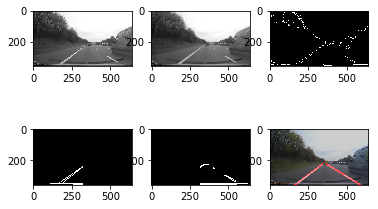

In [27]:

video_output = 'test_op.mp4'
video_clip = clip1.fl_image(process_video) 
get_ipython().magic('time video_clip.write_videofile(video_output, audio=False)')

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

### References

1. docs.opencv.org
2. OpenCV-Python Tutorials Documentation Release 1 by Alexander Mordvintsev & Abid K
3. matplotlib.org
4. numpy.org
5. zulko.github.io/moviepy/
6. https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.linalg.lstsq.html
